In [ ]:
import numpy as np
import pandas as pd

# Generate mock categorical dataset
np.random.seed(42)

source_data = pd.read_csv("data/hh_sample_ipu.csv").drop(columns=["serialno", "sample_geog"]).astype(str)

print("✅ Source categorical data created!")
print(source_data.head())


✅ Source categorical data created!
        dwelltype         owndwell      hhinc totalvehs hhsize
0  Separate House      Fully Owned  1000-1249         2      4
1  Separate House  Being Purchased  1500-1749         3      4
2  Separate House  Being Purchased  1000-1249         2      4
3  Separate House      Fully Owned  1750-1999         3      3
4  Separate House  Being Purchased  1750-1999         1      3


In [34]:
def compute_ecdf_mappings(data):
    """
    Compute ECDF mappings for categorical variables.

    Parameters:
    -----------
    data : pd.DataFrame
        Categorical dataset.

    Returns:
    --------
    dict
        Mapping of categorical values to numerical ECDF space.
    """
    ecdf_mappings = {}

    for column in data.columns:
        unique_values = sorted(data[column].unique())
        ecdf_x = np.array(unique_values)
        ecdf_y = np.linspace(0, 1, len(ecdf_x), endpoint=False)

        ecdf_mappings[column] = {'x': ecdf_x, 'y': ecdf_y}

    return ecdf_mappings

# Compute ECDF mappings
ecdf_mappings = compute_ecdf_mappings(source_data)
print("✅ ECDF mappings computed!")
ecdf_mappings["hhinc"]["x"] = np.append(ecdf_mappings["hhinc"]["x"], "Negative income")
ecdf_mappings["hhinc"]["y"] = np.append(ecdf_mappings["hhinc"]["y"], 0.97)
ecdf_mappings

✅ ECDF mappings computed!


{'dwelltype': {'x': array(['Flat or Apartment', 'Missing', 'Other', 'Separate House',
         'Terrace/Townhouse'], dtype='<U17'),
  'y': array([0. , 0.2, 0.4, 0.6, 0.8])},
 'owndwell': {'x': array(['Being Purchased', 'Being Rented', 'Fully Owned', 'Something Else'],
        dtype='<U15'),
  'y': array([0.  , 0.25, 0.5 , 0.75])},
 'hhinc': {'x': array(['1-149', '1000-1249', '1250-1499', '150-299', '1500-1749',
         '1750-1999', '2000-2499', '2500-2999', '300-399', '3000-3499',
         '3500-3999', '400-499', '4000-4499', '4500-4999', '500-649',
         '5000-5999', '6000-7999', '650-799', '800-999', '8000+',
         'Nil income', 'Negative income'], dtype='<U15'),
  'y': array([0.        , 0.04761905, 0.0952381 , 0.14285714, 0.19047619,
         0.23809524, 0.28571429, 0.33333333, 0.38095238, 0.42857143,
         0.47619048, 0.52380952, 0.57142857, 0.61904762, 0.66666667,
         0.71428571, 0.76190476, 0.80952381, 0.85714286, 0.9047619 ,
         0.95238095, 0.97      ])},
 '

In [92]:
def transform_to_copula_space(data, ecdf_mappings):
    """
    Transform categorical data into copula space using ECDF mappings.

    Parameters:
    -----------
    data : pd.DataFrame
        Categorical dataset.
    ecdf_mappings : dict
        ECDF mappings.

    Returns:
    --------
    pd.DataFrame
        Transformed data in copula space [0,1]^d.
    """
    copula_data = pd.DataFrame()

    for column in data.columns:
        if column == "zone_id":
            continue
        mapping = ecdf_mappings[column]
        copula_data[column] = data[column].map(dict(zip(mapping['x'], mapping['y'])))
    
    if "zone_id" in data.columns:
        copula_data["zone_id"] = data["zone_id"]

    return copula_data

# Transform source data to copula space
copula_data = transform_to_copula_space(source_data, ecdf_mappings)
print("✅ Data transformed to copula space!")
print(copula_data.head())


✅ Data transformed to copula space!
   dwelltype  owndwell     hhinc  totalvehs  hhsize
0        0.6       0.5  0.047619        0.4   0.375
1        0.6       0.0  0.190476        0.6   0.375
2        0.6       0.0  0.047619        0.4   0.375
3        0.6       0.5  0.238095        0.6   0.250
4        0.6       0.0  0.238095        0.2   0.250


In [37]:
from ctgan import CTGAN

def generate_synthetic_copula_data(copula_data):
    """
    Train a CTGAN model and generate synthetic copula samples.

    Parameters:
    -----------
    copula_data : pd.DataFrame
        Data transformed into copula space.
    n_samples : int
        Number of synthetic samples to generate.

    Returns:
    --------
    pd.DataFrame
        Synthetic copula data.
    """
    ctgan = CTGAN(epochs=50)
    ctgan.fit(copula_data)

    return ctgan

# Generate synthetic copula data

ctgan = generate_synthetic_copula_data(copula_data)


In [58]:
census_data = pd.read_csv("data/hh_marginals_ipu.csv", header=[0, 1])
census_data.columns = census_data.columns.to_flat_index()
census_data = census_data.drop(columns=[x for x in census_data.columns if x[0] =="sample_geog"])
census_data = census_data.set_index([x for x in census_data.columns if x[0] =="zone_id"][0])
census_data

,"(hhsize, 1)","(hhsize, 2)","(hhsize, 3)","(hhsize, 4)","(hhsize, 5)","(hhsize, 6)","(hhsize, 7)","(hhsize, 8+)","(dwelltype, Flat or Apartment)","(dwelltype, Missing)",...,"(hhinc, Nil income)","(totalvehs, 0)","(totalvehs, 1)","(totalvehs, 2)","(totalvehs, 3)","(totalvehs, 4+)","(owndwell, Being Purchased)","(owndwell, Being Rented)","(owndwell, Fully Owned)","(owndwell, Something Else)"
"(zone_id, Unnamed: 0_level_1)",,,,,,,,,,,,,,,,,,,,,
3000,10393,8524,2026,656,118,27,4,58,21546,128,...,1916,14688,5445,861,397,415,2453,16601,2284,468
3002,1035,1019,190,101,38,9,0,55,1877,9,...,42,478,1268,545,89,67,434,1298,673,42
3003,1504,1591,476,223,40,11,7,55,3187,6,...,159,1401,1937,420,93,56,797,2548,463,99
3004,2566,2382,511,227,33,6,5,55,5741,27,...,172,1198,3442,882,168,95,1207,3212,1268,98
3006,5113,5033,1280,414,59,13,8,58,11783,40,...,435,4725,5884,1026,193,150,2136,8092,1537,213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3990,6,20,8,4,3,0,0,55,0,0,...,3,13,12,30,25,16,16,0,22,58
3991,37,65,16,19,10,9,0,55,0,0,...,6,20,46,66,42,37,51,17,67,76
3992,134,201,72,60,24,9,0,55,0,0,...,9,12,153,218,93,79,229,55,192,79


In [61]:
sum_zonal = census_data.sum(axis=1)/5
hold_syn_pop = []
for zone, tot in sum_zonal.items():
    syn_pop = ctgan.sample(int(tot))
    syn_pop["zone_id"] = zone
    hold_syn_pop.append(syn_pop)
synthetic_copula_data = pd.concat(hold_syn_pop)
synthetic_copula_data

,dwelltype,owndwell,hhinc,totalvehs,hhsize,zone_id
0,0.599977,-0.000275,0.856622,0.400219,0.126008,3000
1,0.800910,0.499075,0.105667,0.199488,0.125116,3000
2,0.001247,0.249849,0.632198,0.200578,-0.000615,3000
3,0.007348,0.252491,0.762018,0.202190,0.001646,3000
4,0.599909,0.000171,0.267101,0.398765,0.376118,3000
...,...,...,...,...,...,...
2760,0.001142,0.248664,0.012495,0.200328,-0.000264,3996
2761,0.600328,0.500515,0.577581,0.400772,0.125151,3996
2762,0.600620,0.249628,0.662696,0.002762,0.002753,3996
2763,0.800942,0.499189,0.935867,0.199820,0.125297,3996


In [ ]:
# total_hh = census_data.sum().sum() / 5
# synthetic_copula_data = ctgan.sample(int(total_hh))
# print("✅ Synthetic copula data generated!")
# print(synthetic_copula_data.head())

✅ Synthetic copula data generated!
   dwelltype  owndwell     hhinc  totalvehs    hhsize
0   0.601791  0.000253  0.400751   0.199213  0.124591
1   0.600948  0.499243  0.237709   0.400047  0.375541
2   0.802138  0.000805  0.260584   0.400292  0.375963
3   0.601333  0.499704  0.566976   0.202225  0.125559
4   0.601361  0.499085  0.117302   0.200524  0.125276


In [ ]:
# hold = census_data.sum() / total_hh
# target_marginals = {}
# for index, value in hold.items():
#     att, state = index
#     if att not in target_marginals:
#         target_marginals[att] = {state: value}
#     else:
#         target_marginals[att][state] = value

In [71]:
import numpy as np
import pandas as pd

def adjust_copula_to_match_marginals(synthetic_copula_data, target_marginals, ecdf_mappings):
    """
    Adjust synthetic copula samples to match the given marginal distributions 
    using the inverse CDF method from the paper.

    Parameters:
    -----------
    synthetic_copula_data : pd.DataFrame
        Synthetic data in copula space [0,1]^d.
    target_marginals : dict
        Dictionary of target marginal distributions (probabilities) for each attribute.
    ecdf_mappings : dict
        ECDF mappings from original seed data to ensure smooth transformation.

    Returns:
    --------
    pd.DataFrame
        Adjusted synthetic copula data still in [0,1]^d.
    """
    print("📌 Adjusting copula data using inverse CDF method...")

    adjusted_copula_data = synthetic_copula_data.copy()

    for column in synthetic_copula_data.columns:
        if column == "zone_id":
            continue
        u_values = synthetic_copula_data[column].values  # Copula values in [0,1]

        # Convert categorical values in ECDF to numeric (index-based mapping)
        category_to_num = {cat: idx / (len(ecdf_mappings[column]['x']) - 1) for idx, cat in enumerate(ecdf_mappings[column]['x'])}
        num_to_category = {idx / (len(ecdf_mappings[column]['x']) - 1): cat for idx, cat in enumerate(ecdf_mappings[column]['x'])}

        # Convert target marginal categories to numeric
        target_values_numeric = np.array([category_to_num[cat] for cat in target_marginals[column].keys()])
        target_probs = np.array(list(target_marginals[column].values()))
        target_cdf = np.cumsum(target_probs)  # Compute CDF

        # Apply the inverse CDF transformation: find the smallest category where CDF ≥ u
        adjusted_u_values = np.interp(u_values, np.linspace(0, 1, len(target_cdf)), target_cdf)

        # Map back using numerical ECDF scale
        mapped_values = np.interp(adjusted_u_values, target_cdf, target_values_numeric)

        # Normalize adjusted values back to [0,1]
        adjusted_copula_data[column] = (mapped_values - mapped_values.min()) / (mapped_values.max() - mapped_values.min() + 1e-10)

    print("✅ Copula data successfully adjusted while preserving [0,1] structure!")
    return adjusted_copula_data


# Adjust synthetic copula data
# adjusted_synthetic_copula_data = adjust_copula_to_match_marginals(synthetic_copula_data, target_marginals, ecdf_mappings)
# print("✅ Synthetic copula data adjusted to match target marginals!")


In [72]:
def map_back_to_original(adjusted_copula_data, ecdf_mappings):
    """
    Convert numerical copula data back to original categorical values.

    Parameters:
    -----------
    adjusted_copula_data : pd.DataFrame
        Data adjusted in copula space [0,1]^d.
    ecdf_mappings : dict
        ECDF mappings to map back to categorical values.

    Returns:
    --------
    pd.DataFrame
        Final synthetic categorical data.
    """
    categorical_data = pd.DataFrame()

    for column in adjusted_copula_data.columns:
        if column == "zone_id":
            continue
        ecdf_x = ecdf_mappings[column]['x']
        ecdf_y = ecdf_mappings[column]['y']
        categorical_data[column] = [ecdf_x[np.searchsorted(ecdf_y, u, side="right") - 1] for u in adjusted_copula_data[column].values]

    return categorical_data

# Convert back to categorical values
# final_synthetic_data = map_back_to_original(adjusted_synthetic_copula_data, ecdf_mappings)
# print("✅ Final synthetic data mapped back to categorical values!")
# print(final_synthetic_data.head())

In [93]:
wgan_syn = pd.read_csv("data/wgan_synthetic_population.csv")
# wgan_syn = wgan_syn.set_index("zone_id")
synthetic_copula_data = transform_to_copula_space(wgan_syn, ecdf_mappings)
synthetic_copula_data

,dwelltype,owndwell,hhinc,totalvehs,hhsize,zone_id
0,0.6,0.50,0.714286,0.4,0.250,3000
1,0.6,0.50,0.571429,0.4,0.375,3000
2,0.6,0.00,0.476190,0.4,0.375,3000
3,0.6,0.25,0.523810,0.0,0.625,3000
4,0.6,0.50,0.380952,0.2,0.000,3000
...,...,...,...,...,...,...
2420215,0.0,0.50,0.238095,0.4,0.250,3996
2420216,0.6,0.50,0.333333,0.6,0.625,3996
2420217,0.6,0.50,0.142857,0.4,0.125,3996
2420218,0.8,0.50,0.047619,0.4,0.125,3996


In [94]:
hold_final_hh = []
for zone, census_count in census_data.iterrows():
    census_prob = census_count / sum_zonal[zone]
    target_marginals = {}
    for index, value in census_prob.items():
        att, state = index
        if att not in target_marginals:
            target_marginals[att] = {state: value}
        else:
            target_marginals[att][state] = value
    zone_curr = synthetic_copula_data[synthetic_copula_data["zone_id"] == zone]
    adjusted_copula_data = adjust_copula_to_match_marginals(zone_curr, target_marginals, ecdf_mappings)
    synthetic_data = map_back_to_original(adjusted_copula_data, ecdf_mappings)
    synthetic_data["zone_id"] = zone
    hold_final_hh.append(synthetic_data)
final_synthetic_data = pd.concat(hold_final_hh)

📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
📌 Adjusting copula data using inverse CDF method...
✅ Copula data successfully adjusted while preserving [0,1] structure!
📌 Adjusting copula data 

In [95]:
final_synthetic_data.to_csv("output/wgan_copula_syn.csv", index=False)

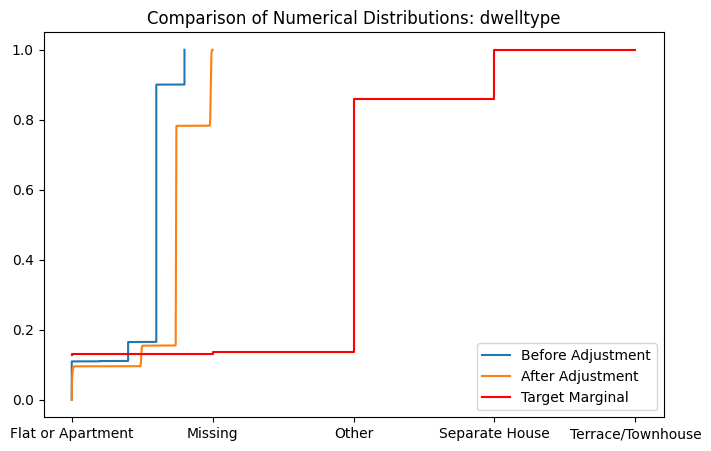

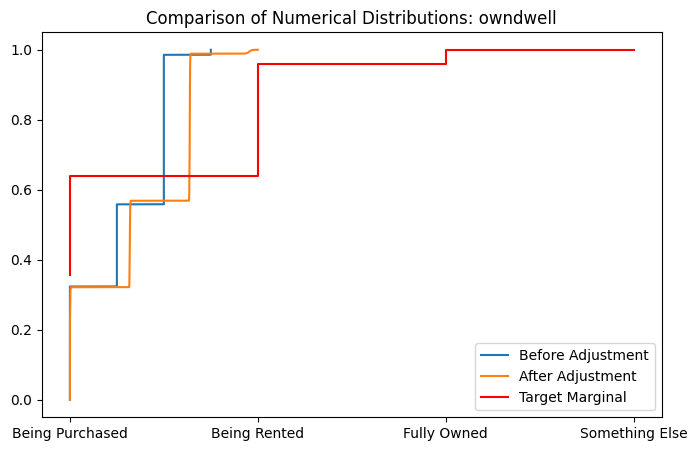

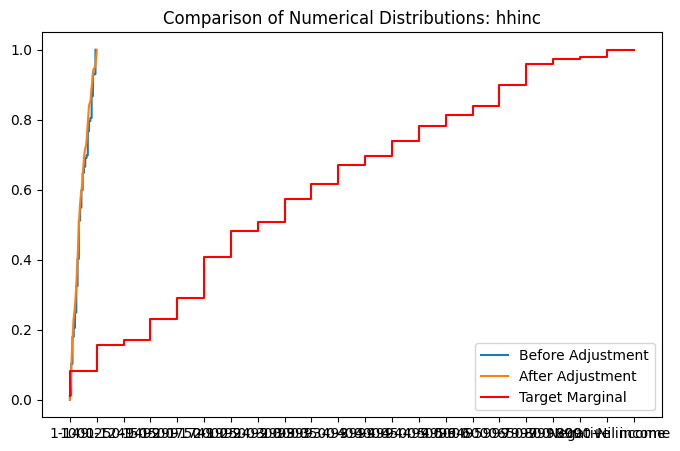

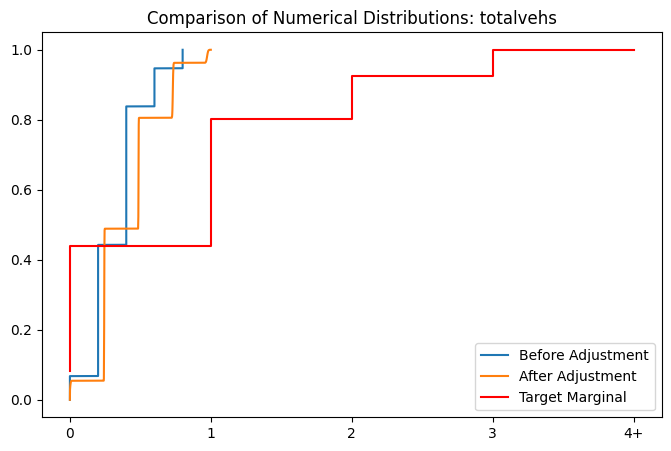

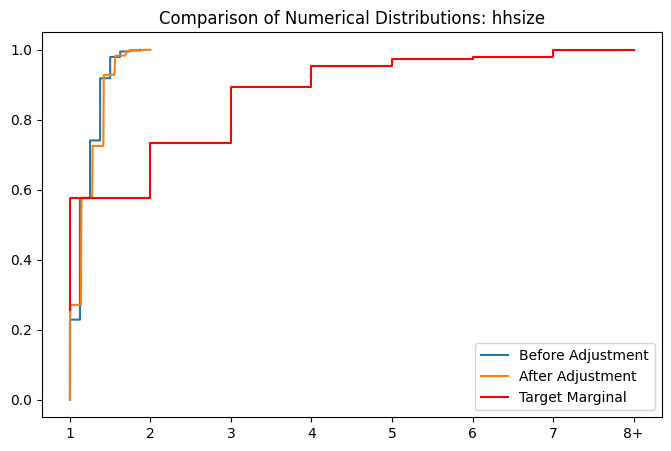

In [ ]:
# import matplotlib.pyplot as plt

# def plot_distribution_comparison(original, adjusted, target, column):
#     plt.figure(figsize=(8,5))

#     # Original ECDF
#     plt.plot(np.sort(original), np.linspace(0, 1, len(original)), label="Before Adjustment")

#     # Adjusted ECDF
#     plt.plot(np.sort(adjusted), np.linspace(0, 1, len(adjusted)), label="After Adjustment")

#     # Target Marginal Distribution (Mapped)
#     plt.step(list(target.keys()), np.cumsum(list(target.values())), label="Target Marginal", color="red")

#     plt.title(f"Comparison of Numerical Distributions: {column}")
#     plt.legend()
#     plt.show()

# for col in source_data.columns:
#     plot_distribution_comparison(copula_data[col], adjusted_synthetic_copula_data[col], target_marginals[col], col)

In [ ]:
# def compute_categorical_distributions(seed_data, before_adjustment_data, after_adjustment_data, target_marginals):
#     """
#     Compute categorical distributions (proportions) for seed data, synthetic data before and after adjustment, and target marginal.

#     Parameters:
#     -----------
#     seed_data : pd.DataFrame
#         The original raw categorical data.
#     before_adjustment_data : pd.DataFrame
#         Synthetic categorical data before marginal adjustment.
#     after_adjustment_data : pd.DataFrame
#         Synthetic categorical data after marginal adjustment.
#     target_marginals : dict
#         Target marginal distributions.

#     Returns:
#     --------
#     dict
#         Dictionary of distributions for each attribute.
#     """
#     distributions = {}

#     for column in seed_data.columns:
#         seed_dist = seed_data[column].value_counts(normalize=True).sort_index()
#         before_dist = before_adjustment_data[column].value_counts(normalize=True).sort_index()
#         after_dist = after_adjustment_data[column].value_counts(normalize=True).sort_index()
#         target_dist = pd.Series(target_marginals[column]).sort_index()

#         distributions[column] = {
#             'Seed': seed_dist,
#             'Before Adjustment': before_dist,
#             'After Adjustment': after_dist,
#             'Target': target_dist
#         }

#     return distributions

# # Compute distributions
# categorical_distributions = compute_categorical_distributions(
#     seed_data=source_data, 
#     before_adjustment_data=map_back_to_original(synthetic_copula_data, ecdf_mappings),
#     after_adjustment_data=final_synthetic_data, 
#     target_marginals=target_marginals
# )

# # Print distributions
# for col, dist in categorical_distributions.items():
#     print(f"\n📊 {col} Distribution Comparison:")
#     print("Seed Data:\n", dist['Seed'])
#     print("Before Adjustment:\n", dist['Before Adjustment'])
#     print("After Adjustment:\n", dist['After Adjustment'])
#     print("Target Marginal:\n", dist['Target'])



📊 dwelltype Distribution Comparison:
Seed Data:
 dwelltype
Flat or Apartment    0.109632
Missing              0.001039
Other                0.054345
Separate House       0.735383
Terrace/Townhouse    0.099601
Name: proportion, dtype: float64
Before Adjustment:
 dwelltype
Flat or Apartment    0.060205
Missing              0.022441
Other                0.187879
Separate House       0.547658
Terrace/Townhouse    0.181817
Name: proportion, dtype: float64
After Adjustment:
 dwelltype
Flat or Apartment    0.095575
Other                0.059049
Separate House       0.628133
Terrace/Townhouse    0.217244
Name: proportion, dtype: float64
Target Marginal:
 Flat or Apartment    0.129252
Missing              0.001288
Other                0.005603
Separate House       0.722174
Terrace/Townhouse    0.141683
dtype: float64

📊 owndwell Distribution Comparison:
Seed Data:
 owndwell
Being Purchased    0.323572
Being Rented       0.234815
Fully Owned        0.427199
Something Else     0.014414
Name: pro

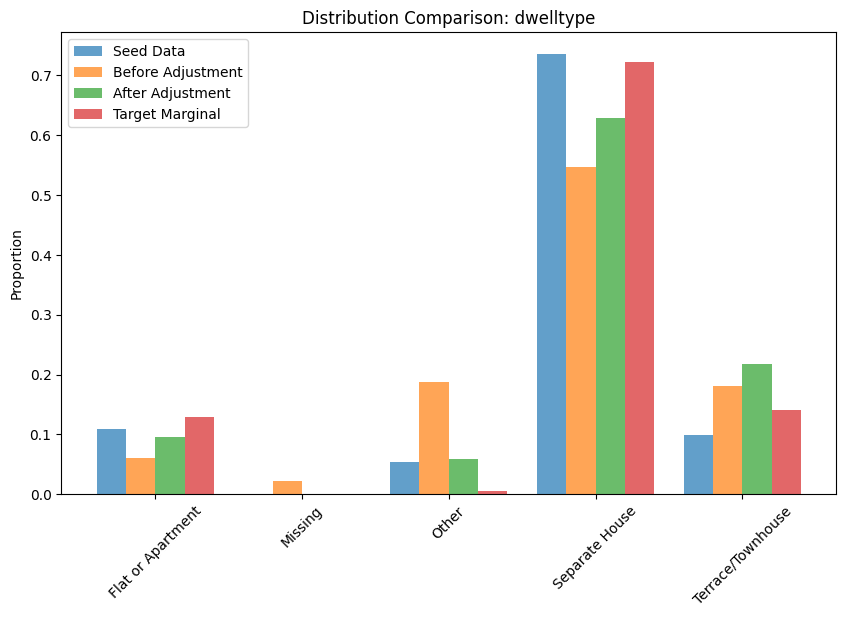

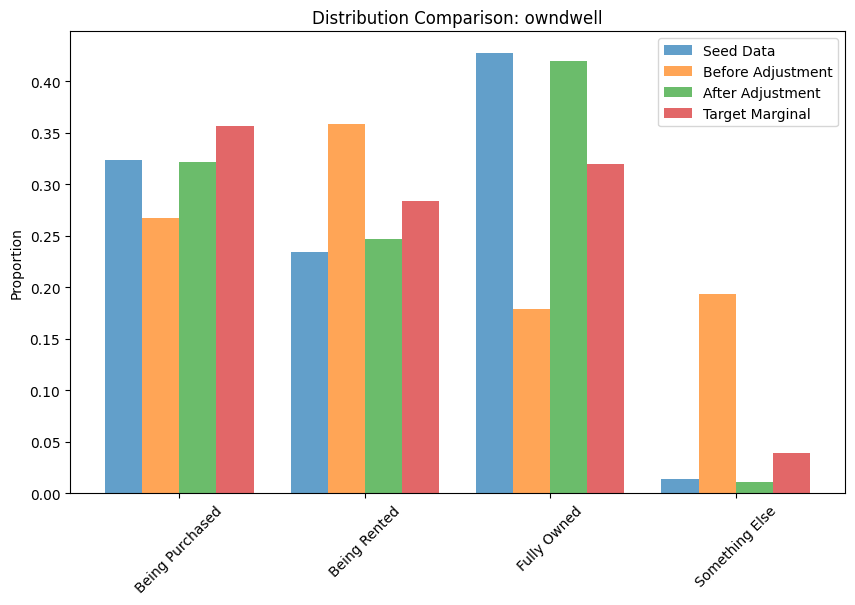

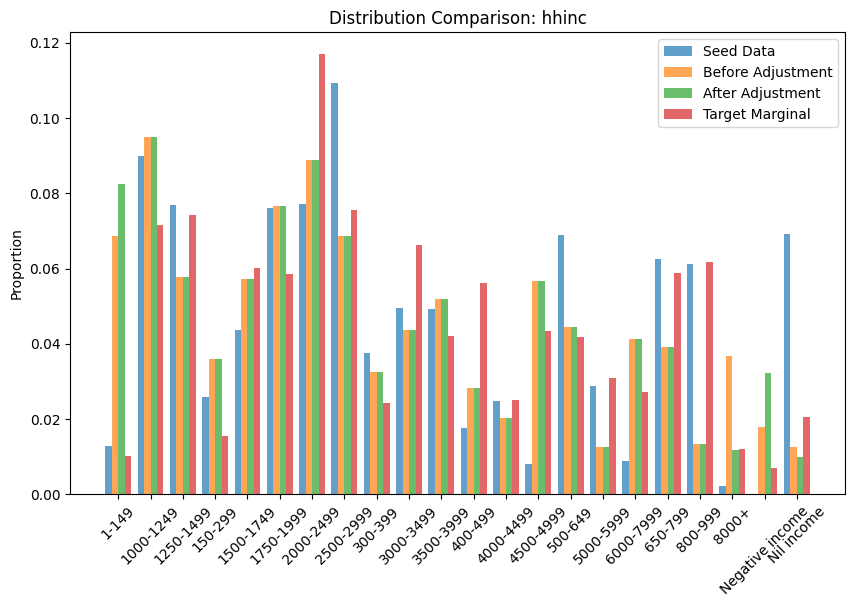

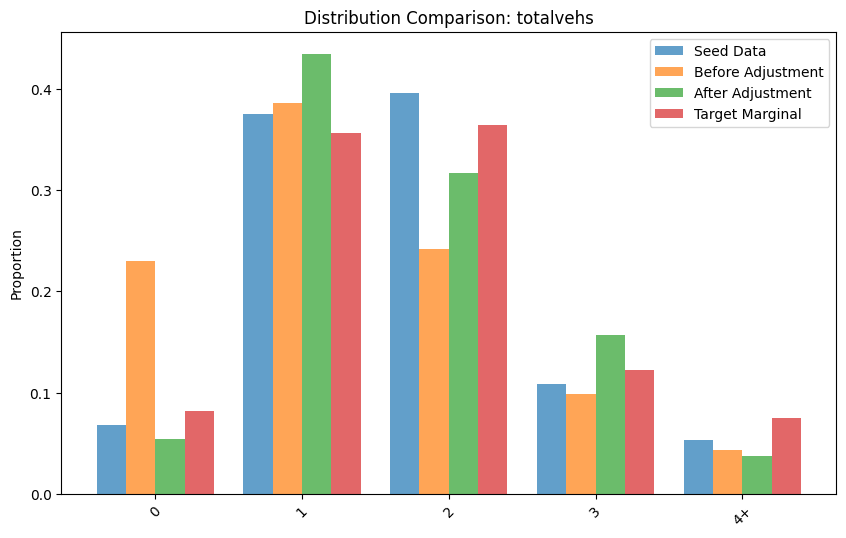

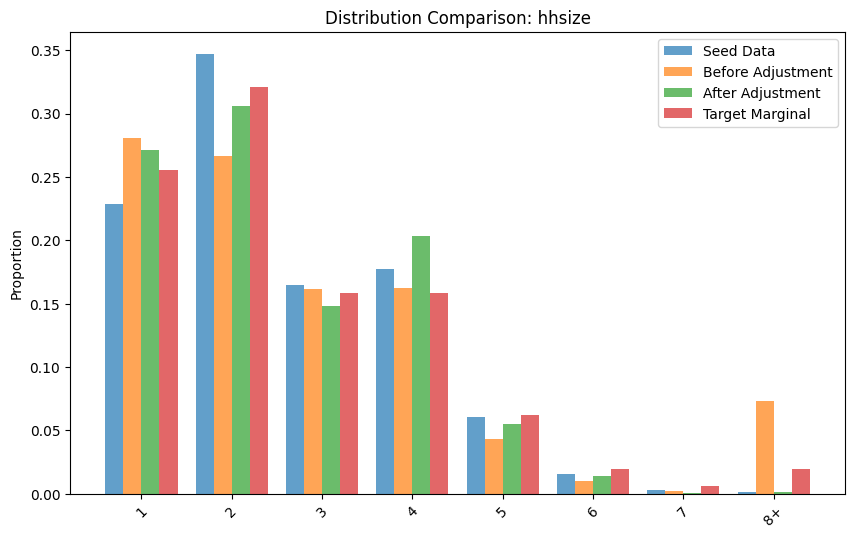

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def plot_categorical_distributions(distributions):
    """
    Plot categorical distributions for seed data, synthetic before adjustment, after adjustment, and target marginals.

    Parameters:
    -----------
    distributions : dict
        Dictionary of categorical distributions.
    """
    for column, dist in distributions.items():
        categories = sorted(set(dist['Seed'].index) | set(dist['Before Adjustment'].index) | 
                            set(dist['After Adjustment'].index) | set(dist['Target'].index))

        seed_values = [dist['Seed'].get(cat, 0) for cat in categories]
        before_values = [dist['Before Adjustment'].get(cat, 0) for cat in categories]
        after_values = [dist['After Adjustment'].get(cat, 0) for cat in categories]
        target_values = [dist['Target'].get(cat, 0) for cat in categories]

        x = np.arange(len(categories))  # Label positions
        width = 0.2  # Width of bars

        plt.figure(figsize=(10, 6))
        plt.bar(x - 1.5*width, seed_values, width, label="Seed Data", alpha=0.7)
        plt.bar(x - 0.5*width, before_values, width, label="Before Adjustment", alpha=0.7)
        plt.bar(x + 0.5*width, after_values, width, label="After Adjustment", alpha=0.7)
        plt.bar(x + 1.5*width, target_values, width, label="Target Marginal", alpha=0.7)

        plt.xticks(ticks=x, labels=categories, rotation=45)
        plt.ylabel("Proportion")
        plt.title(f"Distribution Comparison: {column}")
        plt.legend()
        plt.show()

# Plot categorical distributions
plot_categorical_distributions(categorical_distributions)


In [57]:
from sklearn.metrics import mean_squared_error

def compute_rmse_scores(distributions):
    """
    Compute RMSE between synthetic distributions (before & after adjustment) and the target marginal.

    Parameters:
    -----------
    distributions : dict
        Dictionary containing categorical distributions.

    Returns:
    --------
    dict
        RMSE scores for before and after adjustment.
    """
    rmse_scores = {}

    for column, dist in distributions.items():
        # Align categories across all distributions
        categories = sorted(set(dist['Seed'].index) | set(dist['Before Adjustment'].index) | 
                            set(dist['After Adjustment'].index) | set(dist['Target'].index))

        before_values = np.array([dist['Before Adjustment'].get(cat, 0) for cat in categories])
        after_values = np.array([dist['After Adjustment'].get(cat, 0) for cat in categories])
        target_values = np.array([dist['Target'].get(cat, 0) for cat in categories])

        # Compute RMSE
        rmse_before = np.sqrt(mean_squared_error(target_values, before_values))
        rmse_after = np.sqrt(mean_squared_error(target_values, after_values))

        rmse_scores[column] = {
            'RMSE Before Adjustment': rmse_before,
            'RMSE After Adjustment': rmse_after
        }

    return rmse_scores

# Compute RMSE
rmse_results = compute_rmse_scores(categorical_distributions)

# Print RMSE Scores
print("\n📉 RMSE Scores for Adjustment:")
for col, scores in rmse_results.items():
    print(f"{col}:")
    print(f"  RMSE Before Adjustment: {scores['RMSE Before Adjustment']:.6f}")
    print(f"  RMSE After Adjustment: {scores['RMSE After Adjustment']:.6f}")
    print(f"  🔻 Improvement: {scores['RMSE Before Adjustment'] - scores['RMSE After Adjustment']:.6f}")




📉 RMSE Scores for Adjustment:
dwelltype:
  RMSE Before Adjustment: 0.118748
  RMSE After Adjustment: 0.060902
  🔻 Improvement: 0.057846
owndwell:
  RMSE Before Adjustment: 0.119530
  RMSE After Adjustment: 0.058175
  🔻 Improvement: 0.061355
hhinc:
  RMSE Before Adjustment: 0.022941
  RMSE After Adjustment: 0.024605
  🔻 Improvement: -0.001664
totalvehs:
  RMSE Before Adjustment: 0.088993
  RMSE After Adjustment: 0.048358
  🔻 Improvement: 0.040636
hhsize:
  RMSE Before Adjustment: 0.029472
  RMSE After Adjustment: 0.019420
  🔻 Improvement: 0.010052
